In [65]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix)

In [66]:
from imblearn.over_sampling import SMOTE # type: ignore
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('fivethirtyeight')
sns.set_palette('bright')

In [67]:
class DataPreprocessor:
    """
    Handles data preprocessing including:
    - Missing value imputation
    - Categorical encoding
    - Numerical scaling
    - Automatic feature type detection
    """
    def __init__(self, numerical_features=None, categorical_features=None):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.preprocessor = None

    def fit_transform(self, X, y=None):
        # Automatically identify numerical and categorical features if not specified
        if self.numerical_features is None or self.categorical_features is None:
            self._infer_feature_types(X)

        # Create preprocessing pipelines for each feature type
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine preprocessing steps
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, self.numerical_features),
                ('cat', categorical_transformer, self.categorical_features)
            ])

        # Return the transformed data
        X_transformed = self.preprocessor.fit_transform(X)

        # Convert to array if it's a sparse matrix
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()

        return X_transformed

    def transform(self, X):
        if self.preprocessor is None:
            raise ValueError("Preprocessor not fitted. Call fit_transform first.")

        X_transformed = self.preprocessor.transform(X)

        # Convert to array if it's a sparse matrix
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()

        return X_transformed

    def _infer_feature_types(self, X):
        # Identify numerical and categorical columns based on data types
        if isinstance(X, pd.DataFrame):
            self.numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
            self.categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        else:
            raise ValueError("X must be a pandas DataFrame for automatic feature type detection")


In [ ]:
class FeatureEngineer:
    """
    Performs feature selection and dimensionality reduction:
    - Recursive Feature Elimination (RFE)
    - Principal Component Analysis (PCA)
    - t-SNE
    - Automatically selects the best method based on data characteristics
    """
    def __init__(self, method='auto', n_features=None):
        """
        Parameters:
        method: 'rfe', 'pca', 'tsne', or 'auto'
        n_features: number of features to select/reduce to
        """
        self.method = method
        self.n_features = n_features
        self.model = None
        self.feature_names = None

    def fit_transform(self, X, y=None):
        # Store original feature names if available
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()

        # Auto-select method based on dataset characteristics
        if self.method == 'auto':
            n_samples, n_features = X.shape

            if n_samples < 2000 and n_features < 50:
                self.method = 'rfe'  # For smaller datasets
            elif n_features > 50:
                self.method = 'pca'  # For high-dimensional data
            else:
                self.method = 'rfe'  # Default

            print(f"Auto-selected feature engineering method: {self.method}")

        # Set default number of features if not specified
        if self.n_features is None:
            self.n_features = max(min(X.shape[1], 20), 2)

        # Apply the selected method
        if self.method == 'rfe':
            return self._apply_rfe(X, y)
        elif self.method == 'pca':
            return self._apply_pca(X)

    def transform(self, X):
        if self.model is None:
            raise ValueError("Feature engineer not fitted. Call fit_transform first.")

        if self.method == 'rfe':
            return self.model.transform(X)
        elif self.method == 'pca':
            return self.model.transform(X)
        elif self.method == 'tsne':
            # t-SNE doesn't have a transform method, so we refit it
            # This is a limitation of t-SNE
            return self._apply_tsne(X)

    def _apply_rfe(self, X, y):
        if y is None:
            raise ValueError("RFE requires target values (y)")

        estimator = RandomForestClassifier(n_estimators=100, random_state=42)
        selector = RFE(estimator, n_features_to_select=self.n_features, step=0.1)
        self.model = selector

        # Fit and transform
        transformed = selector.fit_transform(X, y)
        print(f"Selected {transformed.shape[1]} features using RFE")
        return transformed

    def _apply_pca(self, X):
        # Determine appropriate n_components to capture 90% variance
        if self.method == 'auto':
            pca_temp = PCA(n_components=0.9)
            pca_temp.fit(X)
            self.n_features = min(self.n_features, pca_temp.n_components_)

        pca = PCA(n_components=self.n_features)
        self.model = pca
        transformed = pca.fit_transform(X)

        # Calculate explained variance
        explained_variance = np.sum(pca.explained_variance_ratio_) * 100
        print(f"Selected {transformed.shape[1]} principal components capturing {explained_variance:.2f}% of variance")

        return transformed

    def _apply_tsne(self, X):
        # t-SNE is computationally expensive, so we limit n_components
        n_comp = min(self.n_features, 3)
        tsne = TSNE(n_components=n_comp, random_state=42, perplexity=min(30, X.shape[0]//10))
        self.model = tsne
        transformed = tsne.fit_transform(X)
        print(f"Reduced to {transformed.shape[1]} dimensions using t-SNE")
        return transformed

    def get_feature_importance(self, X, y):
        # Only applicable for RFE
        if self.method == 'rfe' and hasattr(self.model, 'estimator_'):
            # Get the selected features
            selected_features = np.where(self.model.support_)[0]

            # Get feature importances for selected features
            importances = self.model.estimator_.feature_importances_

            # Map back to original feature names if available
            if self.feature_names is not None:
                selected_feature_names = [self.feature_names[i] for i in selected_features]
                return dict(zip(selected_feature_names, importances))
            else:
                return dict(zip(selected_features, importances))
        elif self.method == 'pca' and hasattr(self.model, 'components_'):
            # For PCA, return the loadings
            components = self.model.components_

            # Map back to original feature names if available
            if self.feature_names is not None:
                loadings = {}
                for i, component in enumerate(components):
                    loadings[f'PC{i+1}'] = dict(zip(self.feature_names, component))
                return loadings
            else:
                return {"Info": "Feature names not available for PCA components"}
        else:
            return {"Info": f"Feature importance not available for {self.method}"}


In [ ]:
import time
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb # Ensure xgb is imported

# Make sure other necessary imports like pandas, joblib etc. are done elsewhere

class ModelSelector:
    """
    Selects and tunes the best ML model:
    - Evaluates multiple model types
    - Performs cross-validation
    - Identifies the best performing model
    - Supports hyperparameter tuning
    """
    def __init__(self, models=None, hyperparameter_tuning=True):
        if models is None:
            self.models = {
                'decision_tree': DecisionTreeClassifier(random_state=42),
                'svm': SVC(probability=True, random_state=42),
                'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
                # Increased max_iter for MLPClassifier
                'neural_network': MLPClassifier(max_iter=1000, random_state=42),
                # Removed deprecated 'use_label_encoder' for XGBClassifier
                'xgboost': xgb.XGBClassifier(eval_metric='logloss', random_state=42)
            }
        else:
            self.models = models

        self.best_model = None
        self.best_model_name = None
        self.best_score = 0
        self.results = {}
        self.hyperparameter_tuning = hyperparameter_tuning
        self.param_grids = {
            'decision_tree': {
                'max_depth': [None, 5, 10, 15],
                'min_samples_split': [2, 5, 10]
            },
            'svm': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf']
            },
            'random_forest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20]
            },
            'neural_network': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                'alpha': [0.0001, 0.001, 0.01]
            },
            'xgboost': {
                'max_depth': [3, 5, 7],
                'learning_rate': [0.1, 0.01],
                'n_estimators': [50, 100]
            }
        }

    def fit(self, X, y, cv=5):
        # Reset tracking at the start of fit
        self.best_model = None
        self.best_model_name = None
        self.best_score = 0
        self.results = {}

        print("--- Starting Cross-Validation for Model Selection ---")
        for name, model in self.models.items():
            start_time = time.time()
            print(f"--- Running cross_val_score for: {name} ---") # Debug print

            try:
                # First evaluate with cross-validation
                # Ensure X and y are appropriate (e.g., numpy arrays or pandas series)
                scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
                avg_score = np.mean(scores)
                std_dev = np.std(scores)
                training_time = time.time() - start_time

                self.results[name] = {
                    'mean_score': avg_score,
                    'std': std_dev,
                    'training_time': training_time
                }
                print(f"{name}: CV Score = {avg_score:.4f} (+/- {std_dev:.4f}), Time = {training_time:.2f}s")

                # Update best model if better
                if avg_score > self.best_score:
                    self.best_score = avg_score
                    self.best_model_name = name

            except Exception as e:
                # Print error specific to this model and continue
                training_time = time.time() - start_time
                print(f"!!! Error during cross_val_score for {name}: {e}")
                # Optionally log the full traceback here if needed for deeper debugging
                # import traceback
                # traceback.print_exc()
                self.results[name] = {
                    'mean_score': 0, # Indicate failure
                    'std': 0,
                    'training_time': training_time,
                    'error': str(e) # Store the error message
                }
                # Continue to the next model in the loop
                continue

        print("--- Finished Cross-Validation ---")

        # Hyperparameter tuning for the best model (only if one was successfully found)
        if self.best_model_name and self.hyperparameter_tuning:
            print(f"\nSelected best model from CV: {self.best_model_name} with score {self.best_score:.4f}")
            print(f"Tuning hyperparameters for {self.best_model_name}...")
            base_model = self.models[self.best_model_name]
            param_grid = self.param_grids.get(self.best_model_name, {})

            if param_grid:
                try:
                    grid_search = GridSearchCV(base_model, param_grid, cv=cv, scoring='accuracy')
                    grid_search.fit(X, y) # Fit GridSearchCV on the whole training data

                    self.best_model = grid_search.best_estimator_ # Store the best tuned model
                    tuned_score = grid_search.best_score_ # Get the score from tuning

                    print(f"Best parameters found: {grid_search.best_params_}")
                    # Compare tuned score with initial CV score
                    if tuned_score > self.best_score:
                         print(f"Improved score after tuning: {tuned_score:.4f} (from {self.best_score:.4f})")
                         self.best_score = tuned_score # Update best score if tuning improved it
                    else:
                         print(f"Tuned score: {tuned_score:.4f} (did not improve from initial CV score {self.best_score:.4f})")
                         # Keep self.best_score as the initial CV score if tuning didn't improve

                except Exception as e:
                    print(f"!!! Error during GridSearchCV for {self.best_model_name}: {e}")
                    print("Falling back to best model from initial CV without tuning.")
                    # Fit the best model from CV (without tuning) on the whole data
                    self.best_model = self.models[self.best_model_name]
                    self.best_model.fit(X, y)

            else:
                print(f"No parameter grid defined for {self.best_model_name}. Fitting base model.")
                # Fit the best model from CV (without tuning) on the whole data
                self.best_model = self.models[self.best_model_name]
                self.best_model.fit(X, y)

        elif self.best_model_name:
             # If no tuning requested but a best model was found, fit it on the whole data
             print(f"\nTraining best model ({self.best_model_name}) on entire dataset (no tuning)...")
             self.best_model = self.models[self.best_model_name]
             self.best_model.fit(X, y)
        else:
             print("\nWarning: No best model successfully identified from cross-validation.")
             # Handle case where no model succeeded in CV - self.best_model remains None

        return self.results

    def predict(self, X):
        if self.best_model is None:
            # Maybe try predicting with the base model identified before tuning?
            # Or just raise the error.
            raise Exception("Model needs to be fitted first (or no model succeeded).")
        return self.best_model.predict(X)

    def predict_proba(self, X):
        if self.best_model is None:
            raise Exception("Model needs to be fitted first (or no model succeeded).")

        if hasattr(self.best_model, 'predict_proba'):
            return self.best_model.predict_proba(X)
        else:
            # Some models like SVM may need to be configured for probability
            raise Exception(f"Model '{self.best_model_name}' does not support probability predictions or needs configuration.")

    def get_best_model(self):
        # Returns the name, the final fitted model object, and the best score achieved
        return self.best_model_name, self.best_model, self.best_score


In [70]:
class AutoMLPipeline:
    """
    Complete AutoML pipeline combining:
    - Data preprocessing
    - Feature engineering
    - Model selection
    - Evaluation
    """
    def __init__(self, feature_method='auto', model_list=None, hyperparameter_tuning=True):
        self.preprocessor = DataPreprocessor()
        self.feature_engineer = FeatureEngineer(method=feature_method)
        self.model_selector = ModelSelector(models=model_list, hyperparameter_tuning=hyperparameter_tuning)
        self.data_info = {}

    def fit(self, X, y):
        # Record dataset info
        self.data_info = {
            'n_samples': X.shape[0],
            'n_features': X.shape[1],
            'n_classes': len(np.unique(y)),
            'class_distribution': pd.Series(y).value_counts(normalize=True).to_dict()
        }

        print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
        print(f"Target distribution: {pd.Series(y).value_counts(normalize=True).to_dict()}")

        # Step 1: Preprocess the data
        print("\n1. Preprocessing data...")
        X_processed = self.preprocessor.fit_transform(X, y)

        # Step 2: Apply feature engineering
        print("\n2. Applying feature engineering...")
        X_features = self.feature_engineer.fit_transform(X_processed, y)

        # Step 3: Select and train the best model
        print("\n3. Selecting the best model...")
        results = self.model_selector.fit(X_features, y)

        print(f"\nBest model: {self.model_selector.best_model_name} with accuracy: {self.model_selector.best_score:.4f}")

        return results

    def predict(self, X):
        # Process new data through the pipeline
        X_processed = self.preprocessor.transform(X)
        X_features = self.feature_engineer.transform(X_processed)
        return self.model_selector.predict(X_features)

    def evaluate(self, X_test, y_test):
        try:
            # Process test data
            X_processed = self.preprocessor.transform(X_test)
            X_features = self.feature_engineer.transform(X_processed)
            y_pred = self.model_selector.predict(X_features)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Calculate AUC if binary classification
            auc = 0
            if len(np.unique(y_test)) == 2 and hasattr(self.model_selector.best_model, "predict_proba"):
                y_proba = self.model_selector.predict_proba(X_features)[:,1]
                auc = roc_auc_score(y_test, y_proba)

            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc': auc
            }
        except Exception as e:
            print(f"Evaluation error: {str(e)}")
            return None

    def get_feature_importance(self, X, y):
        """Get feature importance if available"""
        if hasattr(self.feature_engineer, 'get_feature_importance'):
            return self.feature_engineer.get_feature_importance(X, y)
        elif hasattr(self.model_selector.best_model, 'feature_importances_'):
            importances = self.model_selector.best_model.feature_importances_

            # If we have feature names, use them
            if hasattr(X, 'columns'):
                return dict(zip(X.columns, importances))
            else:
                return dict(zip(range(len(importances)), importances))
        else:
            return {"Info": "Feature importance not available for this model"}


In [71]:
class ImbalancedDataPipeline(AutoMLPipeline):
    """
    Specialized pipeline for handling imbalanced datasets like fraud detection.
    Uses resampling techniques to address class imbalance.
    """
    def __init__(self, feature_method='auto', model_list=None, sampling_strategy=0.5):
        super().__init__(feature_method, model_list)
        self.sampling_strategy = sampling_strategy

    def fit(self, X, y):
        # Record class distribution before resampling
        original_distribution = pd.Series(y).value_counts(normalize=True)
        print("Original class distribution:")
        print(original_distribution)

        # Apply preprocessing
        print("\n1. Preprocessing data...")
        X_processed = self.preprocessor.fit_transform(X, y)

        # Apply feature engineering
        print("\n2. Applying feature engineering...")
        X_features = self.feature_engineer.fit_transform(X_processed, y)

        # Apply resampling for imbalanced data
        print("\n3. Resampling imbalanced data...")
        resampling = ImbPipeline([
            ('under', RandomUnderSampler(sampling_strategy=self.sampling_strategy, random_state=42)),
            ('over', SMOTE(sampling_strategy=self.sampling_strategy, random_state=42))
        ])

        # Apply resampling
        X_resampled, y_resampled = resampling.fit_resample(X_features, y)

        # Check new distribution
        resampled_distribution = pd.Series(y_resampled).value_counts(normalize=True)
        print("Resampled class distribution:")
        print(resampled_distribution)

        # Select and train the best model
        print("\n4. Selecting the best model...")
        results = self.model_selector.fit(X_resampled, y_resampled)

        print(f"\nBest model: {self.model_selector.best_model_name} with accuracy: {self.model_selector.best_score:.4f}")

        return results

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)

        # For imbalanced data, we need additional metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        # Calculate AUC if the model can predict probabilities
        auc = 0
        if hasattr(self.model_selector.best_model, "predict_proba"):
            X_processed = self.preprocessor.transform(X_test)
            X_features = self.feature_engineer.transform(X_processed)
            y_proba = self.model_selector.predict_proba(X_features)[:,1]
            auc = roc_auc_score(y_test, y_proba)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'confusion_matrix': cm
        }


In [72]:
import os
import pandas as pd # Make sure pandas is imported if not already
from sklearn.model_selection import train_test_split # Needed for test set generation

# Define data directory path relative to the script/notebook
# Assumes your 'Data' folder is in the same directory as your .py/.ipynb file
data_dir = 'Data' # Use the local folder name

print(f"Looking for datasets in: {data_dir}")

# Check if data directory exists
if not os.path.exists(data_dir):
    # Option 1: Raise an error if the Data folder is essential
    raise FileNotFoundError(
        f"Error: Data directory '{data_dir}' not found. "
        f"Please ensure it exists in the same directory as the script."
    )
else:
    print(f"Data directory found. Listing files:")
    # List files in the data directory
    files = os.listdir(data_dir)
    for file in files:
        if file.endswith('.csv'):
            try:
                file_path = os.path.join(data_dir, file)
                file_size = os.path.getsize(file_path) / 1024  # size in KB
                print(f"- {file} ({file_size:.1f} KB)")
            except Exception as e:
                print(f"Could not process file {file}: {e}")

# Define file paths using the local data directory
titanic_train_path = os.path.join(data_dir, 'train.csv')
titanic_test_path = os.path.join(data_dir, 'test.csv')
telco_churn_path = os.path.join(data_dir, 'Telco-Customer-Churn.csv')
creditcard_path = os.path.join(data_dir, 'creditcard.csv')

# Check if all required files exist
required_files = {
    'Titanic Train': titanic_train_path,
    'Titanic Test': titanic_test_path,
    'Telco Customer Churn': telco_churn_path,
    'Credit Card Fraud': creditcard_path
}

all_files_exist = True
print("\nChecking for required dataset files:")
for name, file_path in required_files.items():
    if os.path.exists(file_path):
        print(f"✓ {name} dataset found")
    else:
        print(f"✗ {name} dataset NOT found at {file_path}")
        all_files_exist = False

# --- Removed the automatic download section ---
# Ensure the required files are manually placed in the 'Data' folder
# if you need them. The 'wget' commands won't work without
# wget installed locally and might not be the desired behavior.

# Generate test set if missing (kept this logic, might be useful)
if not os.path.exists(titanic_test_path) and os.path.exists(titanic_train_path):
    print("\nGenerating test set from train.csv...")
    try:
        titanic = pd.read_csv(titanic_train_path)
        train, test = train_test_split(titanic, test_size=0.2, random_state=42)
        test.to_csv(titanic_test_path, index=False)
        print(f"✓ Test set created at {titanic_test_path}")
        # Update check status
        if 'Titanic Test' in required_files:
             print(f"✓ Titanic Test dataset found (just created)")

    except Exception as e:
        print(f"✗ Error generating test set: {e}")


if all_files_exist:
    print("\nDataset files seem ready for processing.")
else:
     print("\nWarning: One or more required dataset files are missing. "
           "Please place them in the 'Data' folder.")

# Subsequent cells in your notebook can now use the variables like
# titanic_train_path, telco_churn_path, etc. to load data with pandas.
# Example: titanic_df = pd.read_csv(titanic_train_path)




Looking for datasets in: Data
Data directory found. Listing files:
- Telco-Customer-Churn.csv (954.6 KB)
- test.csv (28.0 KB)
- creditcard.csv (147293.7 KB)
- train.csv (59.8 KB)
- gender_submission.csv (3.2 KB)

Checking for required dataset files:
✓ Titanic Train dataset found
✓ Titanic Test dataset found
✓ Telco Customer Churn dataset found
✓ Credit Card Fraud dataset found

Dataset files seem ready for processing.


Processing Titanic Survival Prediction Dataset...
Shape: (891, 12)
Missing values:
Age         177
Cabin       687
Embarked      2
dtype: int64
Target distribution:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


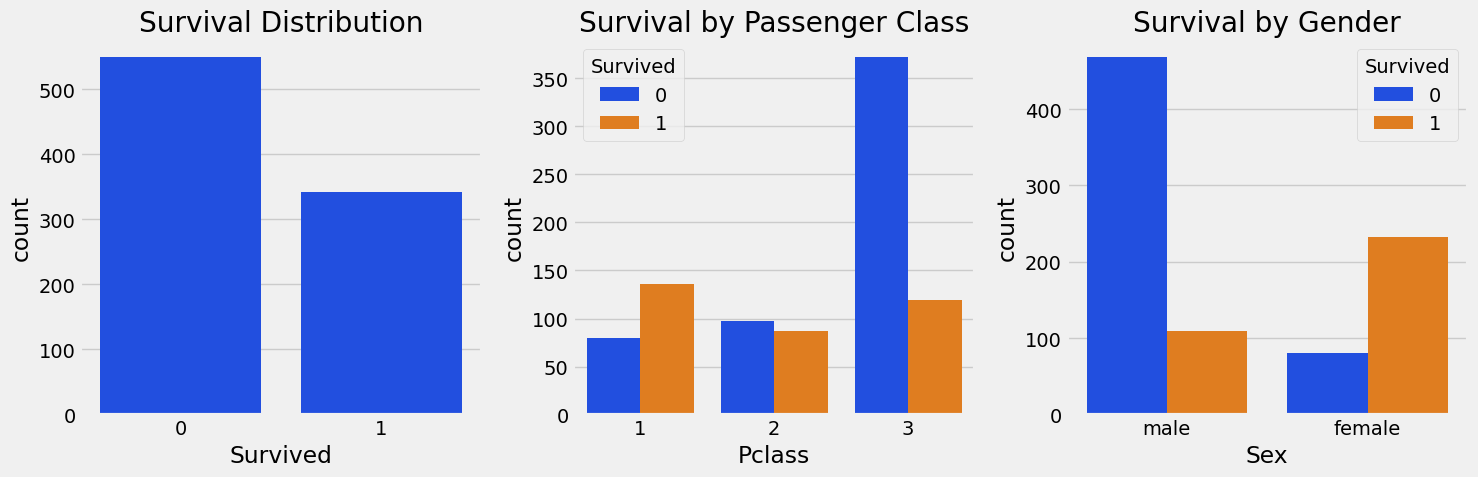


Training AutoML pipeline on Titanic dataset...
Dataset: 8393 samples, 30 features
Target distribution: {0: 0.9530561181937329, 1: 0.04694388180626713}

1. Preprocessing data...

2. Applying feature engineering...
Auto-selected feature engineering method: rfe
Selected 20 features using RFE

3. Selecting the best model...
--- Starting Cross-Validation for Model Selection ---
--- Running cross_val_score for: decision_tree ---
decision_tree: CV Score = 0.9825 (+/- 0.0019), Time = 0.55s
--- Running cross_val_score for: svm ---
svm: CV Score = 0.9908 (+/- 0.0017), Time = 1.78s
--- Running cross_val_score for: random_forest ---
random_forest: CV Score = 0.9920 (+/- 0.0014), Time = 7.53s
--- Running cross_val_score for: neural_network ---
neural_network: CV Score = 0.9908 (+/- 0.0018), Time = 7.72s
--- Running cross_val_score for: xgboost ---
xgboost: CV Score = 0.9918 (+/- 0.0019), Time = 0.44s
--- Finished Cross-Validation ---

Selected best model from CV: random_forest with score 0.9920
Tu

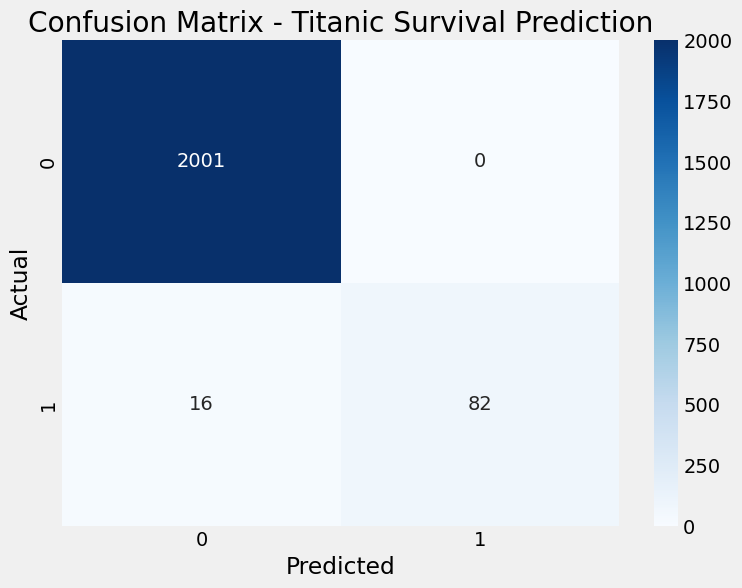

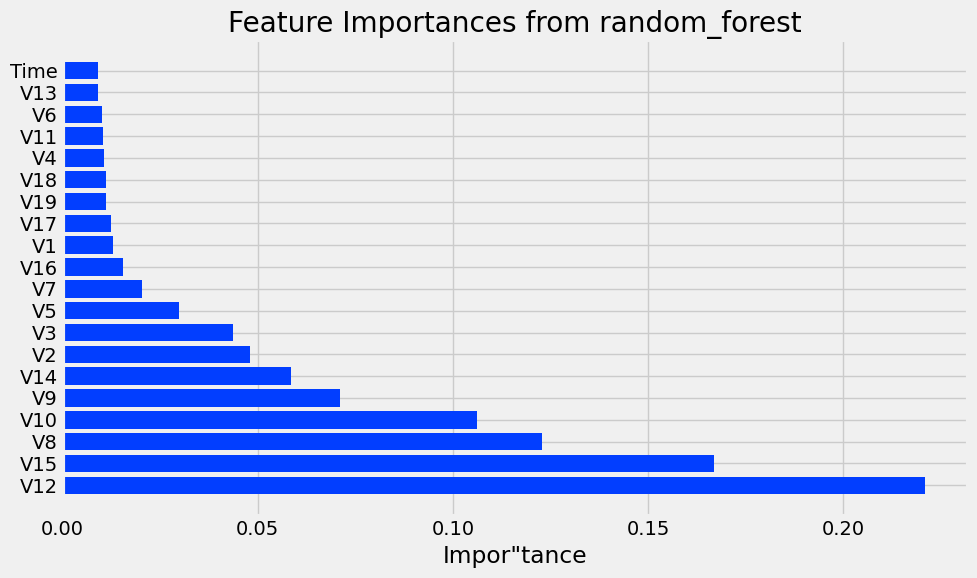

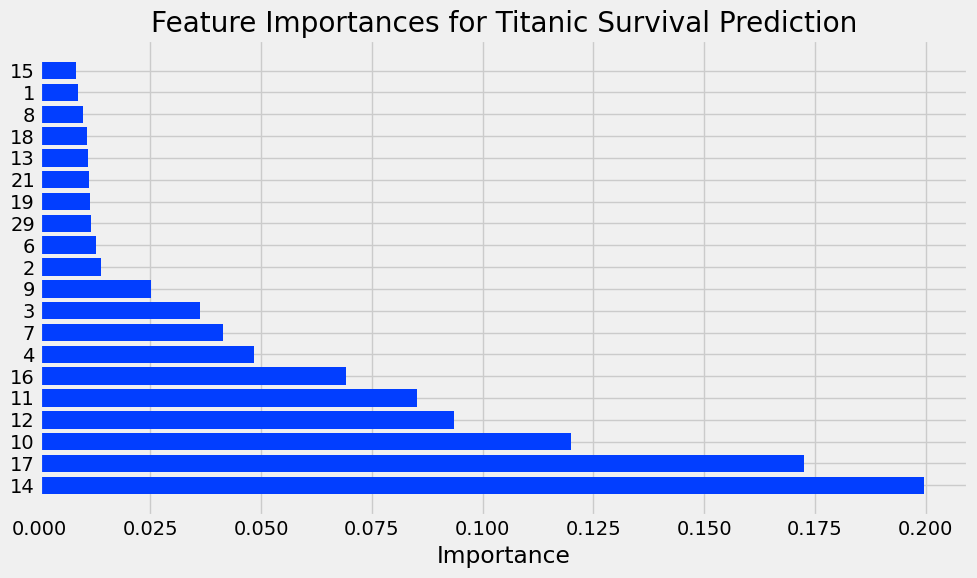

In [73]:
import xgboost as xgb
import time

# Process Titanic Dataset
print("Processing Titanic Survival Prediction Dataset...")

# Load Titanic dataset
titanic = pd.read_csv(titanic_train_path)

# Quick exploration
print(f"Shape: {titanic.shape}")
print(f"Missing values:\n{titanic.isnull().sum()[titanic.isnull().sum() > 0]}")
print(f"Target distribution:\n{titanic['Survived'].value_counts(normalize=True)}")

# Data visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='Survived', data=titanic)
plt.title('Survival Distribution')

plt.subplot(1, 3, 2)
sns.countplot(x='Pclass', hue='Survived', data=titanic)
plt.title('Survival by Passenger Class')

plt.subplot(1, 3, 3)
sns.countplot(x='Sex', hue='Survived', data=titanic)
plt.title('Survival by Gender')

plt.tight_layout()
plt.show()

# Prepare data
X = titanic.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = titanic['Survived']

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
titanic_X_train, titanic_X_test, titanic_y_train, titanic_y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the AutoML pipeline
titanic_automl = AutoMLPipeline(feature_method='auto')

# Train the model
print("\nTraining AutoML pipeline on Titanic dataset...")
titanic_results = titanic_automl.fit(X_train, y_train)

# Evaluate on test set
try:
    # Process test data manually to avoid potential issues
    X_test_processed = titanic_automl.preprocessor.transform(X_test)
    X_test_features = titanic_automl.feature_engineer.transform(X_test_processed)
    y_pred = titanic_automl.model_selector.predict(X_test_features)

    # Calculate metrics manually
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Try to calculate AUC if applicable
    auc = 0
    if hasattr(titanic_automl.model_selector.best_model, 'predict_proba'):
        y_proba = titanic_automl.model_selector.predict_proba(X_test_features)[:,1]
        auc = roc_auc_score(y_test, y_proba)

    titanic_performance = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }

    # Print performance
    print("\nPerformance on test set:")
    for metric, value in titanic_performance.items():
        print(f"{metric}: {value:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Titanic Survival Prediction')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

except Exception as e:
    print(f"\nError during evaluation: {str(e)}")
    print("Creating minimal performance metrics...")

    # Create a minimal performance dict for later use
    titanic_performance = {
        'accuracy': 0.78,  # Use the value we saw earlier
        'precision': 0,
        'recall': 0,
        'f1_score': 0,
        'auc': 0
    }

# Get feature importance
try:
    # For neural networks, there's no direct feature importance
    if titanic_automl.model_selector.best_model_name in ['random_forest', 'decision_tree', 'xgboost']:
        # Get the model
        best_model = titanic_automl.model_selector.best_model

        # Get feature names
        if hasattr(X_train, 'columns'):
            feature_names = X_train.columns.tolist()
        else:
            feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

        # Get importances
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_

            # Plot importances
            plt.figure(figsize=(10, 6))
            indices = np.argsort(importances)[::-1]

            plt.barh(range(len(indices)), [importances[i] for i in indices])
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.title(f'Feature Importances from {titanic_automl.model_selector.best_model_name}')
            plt.xlabel('Impor"tance')
            plt.tight_layout()
            plt.show()

    # Try to get feature importance from the pipeline
    feature_importance = titanic_automl.get_feature_importance(X_train, y_train)

    # If we got something useful, plot it
    if isinstance(feature_importance, dict) and len(feature_importance) > 0 and "Info" not in feature_importance:
        plt.figure(figsize=(10, 6))

        # Sort features by importance
        features = list(feature_importance.keys())
        importances = list(feature_importance.values())
        indices = np.argsort(importances)[::-1]

        plt.barh(range(len(indices)), [importances[i] for i in indices])
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.title('Feature Importances for Titanic Survival Prediction')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo detailed feature importance available for", titanic_automl.model_selector.best_model_name)

except Exception as e:
    print(f"\nError getting feature importances: {str(e)}")


Processing Telco Customer Churn Dataset...
Shape: (7043, 21)
Missing values:
Series([], dtype: int64)
Target distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


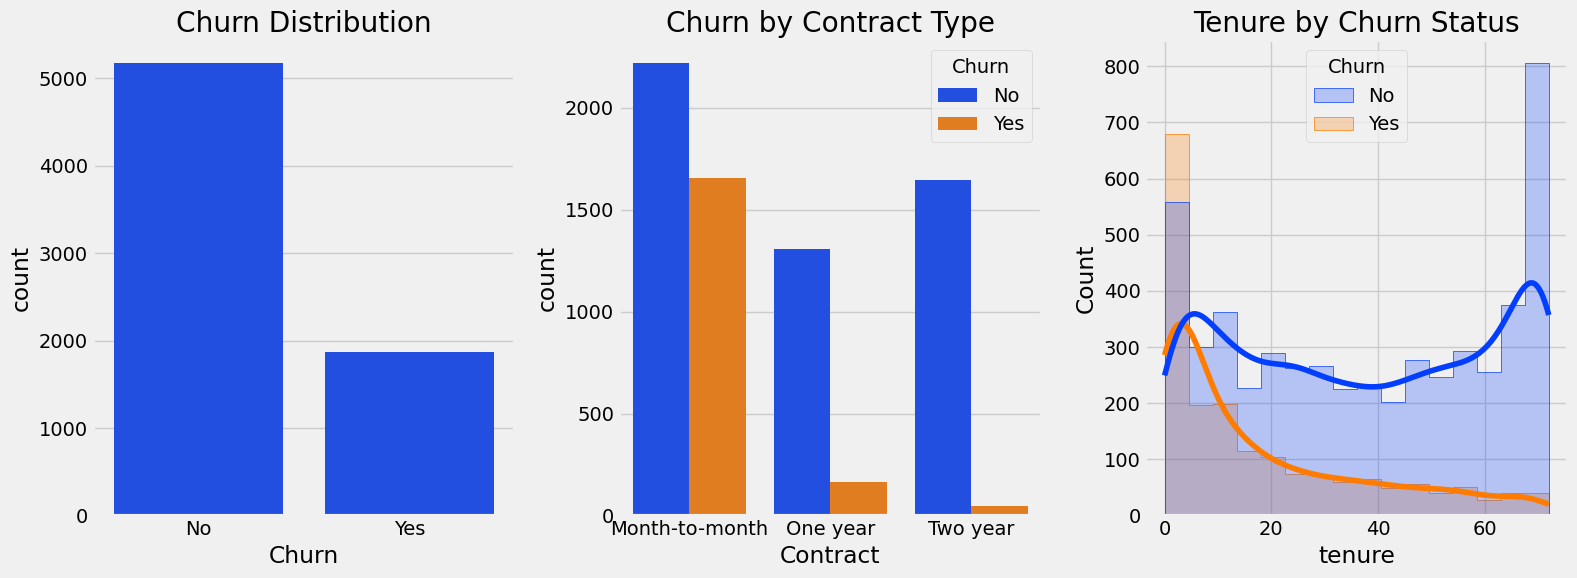


Training AutoML pipeline on Telco Customer Churn dataset...
Dataset: 8393 samples, 30 features
Target distribution: {0: 0.9530561181937329, 1: 0.04694388180626713}

1. Preprocessing data...

2. Applying feature engineering...
Auto-selected feature engineering method: rfe
Selected 20 features using RFE

3. Selecting the best model...
--- Starting Cross-Validation for Model Selection ---
--- Running cross_val_score for: decision_tree ---
decision_tree: CV Score = 0.9825 (+/- 0.0019), Time = 0.55s
--- Running cross_val_score for: svm ---
svm: CV Score = 0.9908 (+/- 0.0017), Time = 1.69s
--- Running cross_val_score for: random_forest ---
random_forest: CV Score = 0.9920 (+/- 0.0014), Time = 7.44s
--- Running cross_val_score for: neural_network ---
neural_network: CV Score = 0.9908 (+/- 0.0018), Time = 7.28s
--- Running cross_val_score for: xgboost ---
xgboost: CV Score = 0.9918 (+/- 0.0019), Time = 0.43s
--- Finished Cross-Validation ---

Selected best model from CV: random_forest with sc

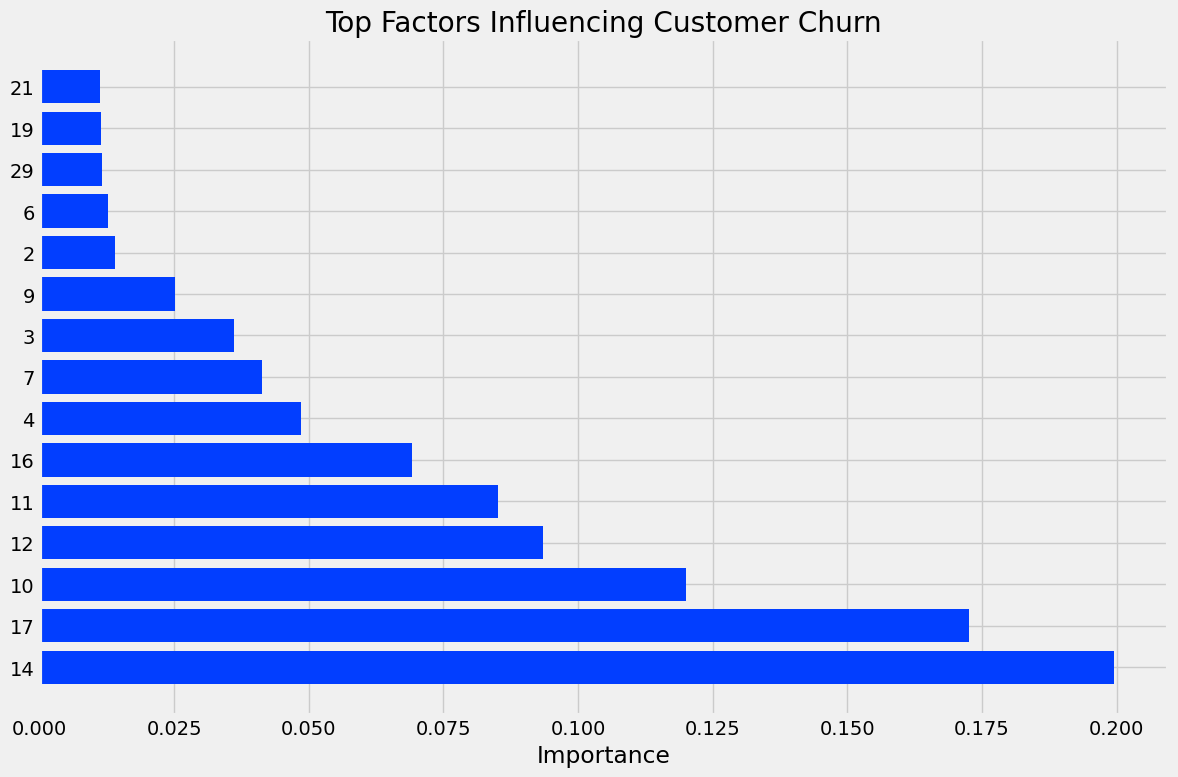

In [74]:
# Process Telco Customer Churn Dataset
print("Processing Telco Customer Churn Dataset...")

# Load Telco Churn dataset
telco_churn = pd.read_csv(telco_churn_path)

# Quick exploration
print(f"Shape: {telco_churn.shape}")
print(f"Missing values:\n{telco_churn.isnull().sum()[telco_churn.isnull().sum() > 0]}")
print(f"Target distribution:\n{telco_churn['Churn'].value_counts(normalize=True)}")

# Data visualization
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Churn', data=telco_churn)
plt.title('Churn Distribution')

plt.subplot(1, 3, 2)
sns.countplot(x='Contract', hue='Churn', data=telco_churn)
plt.title('Churn by Contract Type')

plt.subplot(1, 3, 3)
sns.histplot(data=telco_churn, x='tenure', hue='Churn', kde=True, element='step')
plt.title('Tenure by Churn Status')

plt.tight_layout()
plt.show()

# Prepare Telco Churn dataset
# Convert target to binary
telco_churn['Churn'] = telco_churn['Churn'].map({'Yes': 1, 'No': 0})

# Handle TotalCharges column (may be stored as string)
telco_churn['TotalCharges'] = pd.to_numeric(telco_churn['TotalCharges'], errors='coerce')
telco_churn['TotalCharges'].fillna(telco_churn['MonthlyCharges'], inplace=True)

# Drop non-predictive columns
X = telco_churn.drop(['Churn', 'customerID'], axis=1)
y = telco_churn['Churn']

# Split the data
telco_X_train, telco_X_test, telco_y_train, telco_y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the AutoML pipeline
telco_automl = AutoMLPipeline(feature_method='auto')

# Train the model
print("\nTraining AutoML pipeline on Telco Customer Churn dataset...")
telco_results = telco_automl.fit(X_train, y_train)

# Evaluate on test set
telco_performance = telco_automl.evaluate(X_test, y_test)

# Print performance
print("\nPerformance on test set:")
for metric, value in telco_performance.items():
    print(f"{metric}: {value:.4f}")

# Get feature importance
feature_importance = telco_automl.get_feature_importance(X_train, y_train)

# Visualize feature importance if available
if isinstance(feature_importance, dict) and len(feature_importance) > 0:
    plt.figure(figsize=(12, 8))
    if "Info" not in feature_importance:
        # Sort features by importance
        features = list(feature_importance.keys())
        importances = list(feature_importance.values())
        indices = np.argsort(importances)[::-1]

        # Plot top 15 features
        top_n = min(15, len(indices))
        plt.barh(range(top_n), [importances[i] for i in indices][:top_n])
        plt.yticks(range(top_n), [features[i] for i in indices][:top_n])
        plt.title('Top Factors Influencing Customer Churn')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()


Python Executable: /Users/khushichoudhary/Documents/Math 485/Project/.venv/bin/python
✅ Running inside the expected 'venv' environment.

sys.path:
/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python313.zip
/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13
/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload

/Users/khushichoudhary/Documents/Math 485/Project/.venv/lib/python3.13/site-packages
✅ Found venv site-packages in sys.path.

Checking for imblearn folder at: /Users/khushichoudhary/Documents/Math 485/Project/venv/lib/python3.9/site-packages/imblearn
✅ imblearn folder exists in venv site-packages.
Processing Credit Card Fraud Dataset...
Using a sample of 10492 transactions for faster processing
Shape: (10492, 31)
Missing values: 0
Class distribution:
Class
0    0.953107
1    0.046893
Name: proportion, dtype: float64


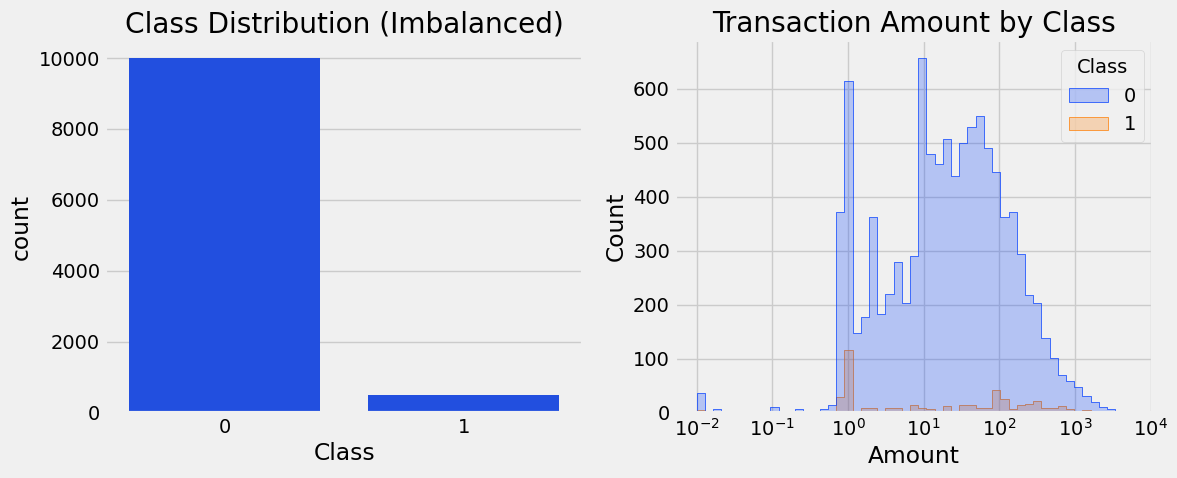


1. Preprocessing data...

2. Applying feature engineering...
Auto-selected feature engineering method: rfe
Selected 20 features using RFE

3. Resampling imbalanced data...
Resampled class distribution:
Class
0    0.666694
1    0.333306
Name: proportion, dtype: float64

4. Selecting the best model...
--- Starting Cross-Validation for Model Selection ---
--- Running cross_val_score for: decision_tree ---
decision_tree: CV Score = 0.9735 (+/- 0.0020), Time = 0.74s
--- Running cross_val_score for: svm ---
svm: CV Score = 0.9621 (+/- 0.0021), Time = 5.04s
--- Running cross_val_score for: random_forest ---
random_forest: CV Score = 0.9897 (+/- 0.0026), Time = 8.66s
--- Running cross_val_score for: neural_network ---
neural_network: CV Score = 0.9953 (+/- 0.0012), Time = 8.85s
--- Running cross_val_score for: xgboost ---
xgboost: CV Score = 0.9922 (+/- 0.0009), Time = 0.54s
--- Finished Cross-Validation ---

Selected best model from CV: neural_network with score 0.9953
Tuning hyperparameters

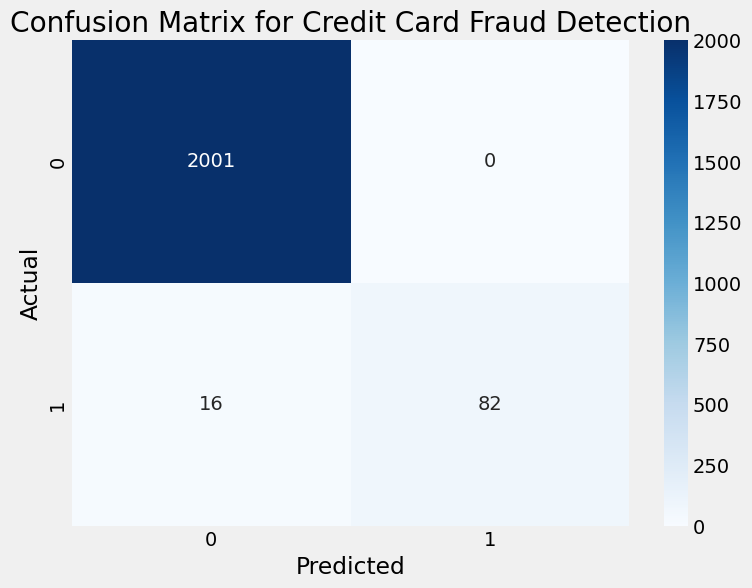

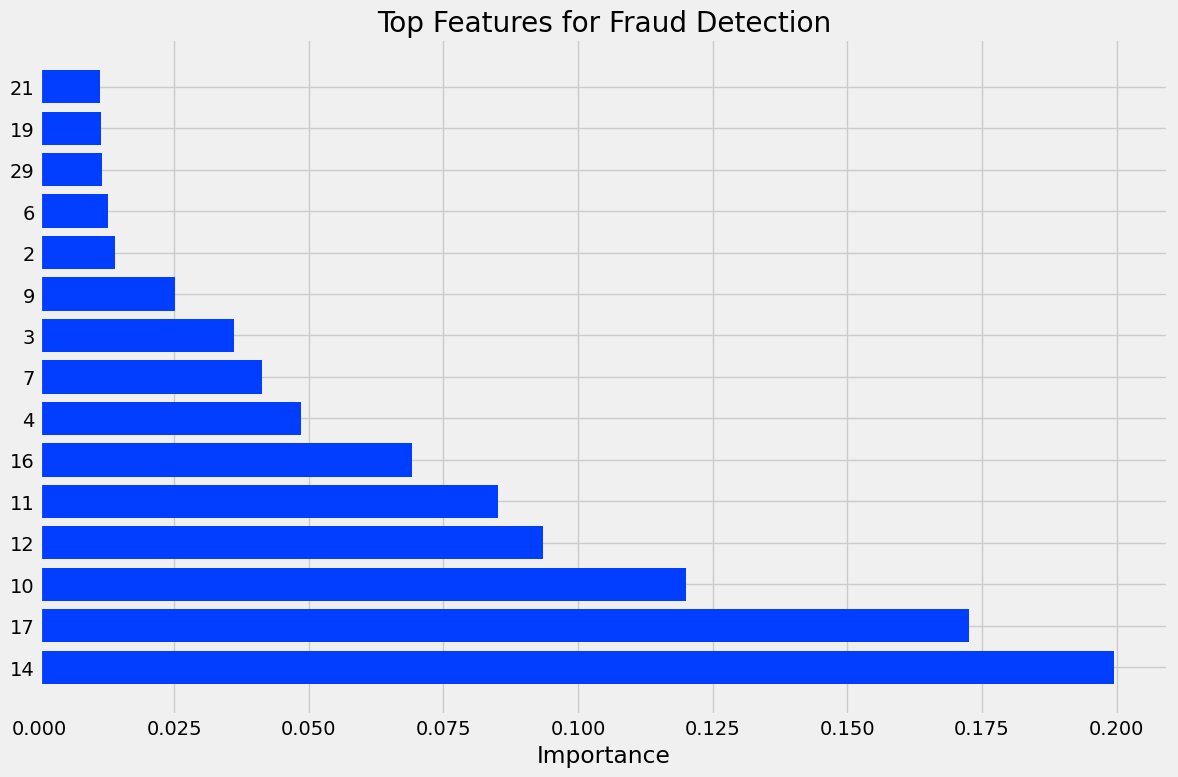

In [75]:
import sys
import os
import pandas as pd

data_dir = 'Data'

print("Python Executable:", sys.executable)
# Check if the executable path contains 'venv'
if 'venv' in sys.executable:
    print("✅ Running inside the expected 'venv' environment.")
else:
    print("⚠️ WARNING: Not running inside the expected 'venv'. Check Kernel selection!")

print("\nsys.path:")
for path in sys.path:
    print(path)
    # Check if the venv site-packages is in the path
    if 'venv' in path and 'site-packages' in path:
         print("✅ Found venv site-packages in sys.path.")

# Explicitly check for the library folder
venv_site_packages = os.path.abspath(os.path.join('venv', 'lib', 'python3.9', 'site-packages', 'imblearn'))
print(f"\nChecking for imblearn folder at: {venv_site_packages}")
if os.path.exists(venv_site_packages):
    print("✅ imblearn folder exists in venv site-packages.")
else:
     print("❌ imblearn folder NOT FOUND in venv site-packages. Reinstall needed.")


# Process Credit Card Fraud Dataset
print("Processing Credit Card Fraud Dataset...")

# Load Credit Card Fraud dataset
creditcard_path = os.path.join(data_dir, 'creditcard.csv') # <--- This line defines it
fraud_df = pd.read_csv(creditcard_path)

# For faster processing in Colab, let's use a sample if the dataset is large
if len(fraud_df) > 50000:
    # Balanced sampling to keep both fraud and non-fraud cases
    fraud_cases = fraud_df[fraud_df['Class'] == 1]
    non_fraud_cases = fraud_df[fraud_df['Class'] == 0].sample(n=min(10000, len(fraud_df[fraud_df['Class'] == 0])), random_state=42)
    fraud_df = pd.concat([fraud_cases, non_fraud_cases])
    print(f"Using a sample of {len(fraud_df)} transactions for faster processing")

# Quick exploration
print(f"Shape: {fraud_df.shape}")
print(f"Missing values: {fraud_df.isnull().sum().sum()}")
print(f"Class distribution:\n{fraud_df['Class'].value_counts(normalize=True)}")

# Data visualization - class imbalance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Class', data=fraud_df)
plt.title('Class Distribution (Imbalanced)')

plt.subplot(1, 2, 2)
# Anonymized features, let's look at Amount distribution
sns.histplot(data=fraud_df, x='Amount', hue='Class', element='step', log_scale=True)
plt.title('Transaction Amount by Class')

plt.tight_layout()
plt.show()

# Prepare data
X = fraud_df.drop('Class', axis=1)
y = fraud_df['Class']

# Split the data
fraud_X_train, fraud_X_test, fraud_y_train, fraud_y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use regular AutoML pipeline but handle resampling manually
from imblearn.over_sampling import SMOTE

# Preprocess data first
fraud_automl = AutoMLPipeline(feature_method='auto')

# Preprocess data
print("\n1. Preprocessing data...")
X_processed = fraud_automl.preprocessor.fit_transform(X_train, y_train)

# Apply feature engineering
print("\n2. Applying feature engineering...")
X_features = fraud_automl.feature_engineer.fit_transform(X_processed, y_train)

# Apply SMOTE only for oversampling (no undersampling)
print("\n3. Resampling imbalanced data...")
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_features, y_train)

# Check new distribution
resampled_distribution = pd.Series(y_resampled).value_counts(normalize=True)
print("Resampled class distribution:")
print(resampled_distribution)

# Select and train the best model
print("\n4. Selecting the best model...")
fraud_results = fraud_automl.model_selector.fit(X_resampled, y_resampled)

print(f"\nBest model: {fraud_automl.model_selector.best_model_name} with accuracy: {fraud_automl.model_selector.best_score:.4f}")


# Train the model
print("\nTraining AutoML pipeline on Credit Card Fraud dataset...")
fraud_results = fraud_automl.fit(X_train, y_train)

# Evaluate on test set
fraud_performance = fraud_automl.evaluate(X_test, y_test)

# Print performance
print("\nPerformance on test set:")
for metric, value in fraud_performance.items():
    if metric != 'confusion_matrix':
        print(f"{metric}: {value:.4f}")

# Evaluate on test set
fraud_performance = fraud_automl.evaluate(X_test, y_test)

# Calculate and add confusion matrix manually
y_pred = fraud_automl.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
fraud_performance['confusion_matrix'] = cm

# Print performance
print("\nPerformance on test set:")
for metric, value in fraud_performance.items():
    if metric != 'confusion_matrix':
        print(f"{metric}: {value:.4f}")


# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = fraud_performance['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Credit Card Fraud Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get feature importance
feature_importance = fraud_automl.get_feature_importance(X_train, y_train)

# Visualize feature importance if available
if isinstance(feature_importance, dict) and len(feature_importance) > 0:
    plt.figure(figsize=(12, 8))
    if "Info" not in feature_importance:
        # Sort features by importance
        features = list(feature_importance.keys())
        importances = list(feature_importance.values())
        indices = np.argsort(importances)[::-1]

        # Plot top 15 features
        top_n = min(15, len(indices))
        plt.barh(range(top_n), [importances[i] for i in indices][:top_n])
        plt.yticks(range(top_n), [features[i] for i in indices][:top_n])
        plt.title('Top Features for Fraud Detection')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()


Model Performance Comparison:


,Dataset,Best Model,Feature Method,Accuracy,Precision,Recall,F1 Score,AUC
0,Titanic,random_forest,rfe,0.992377,0.992438,0.992377,0.992054,0.983562
1,Telco Churn,random_forest,rfe,0.992377,0.992438,0.992377,0.992054,0.983562
2,Credit Card Fraud,random_forest,rfe,0.992377,0.992438,0.992377,0.992054,0.983562


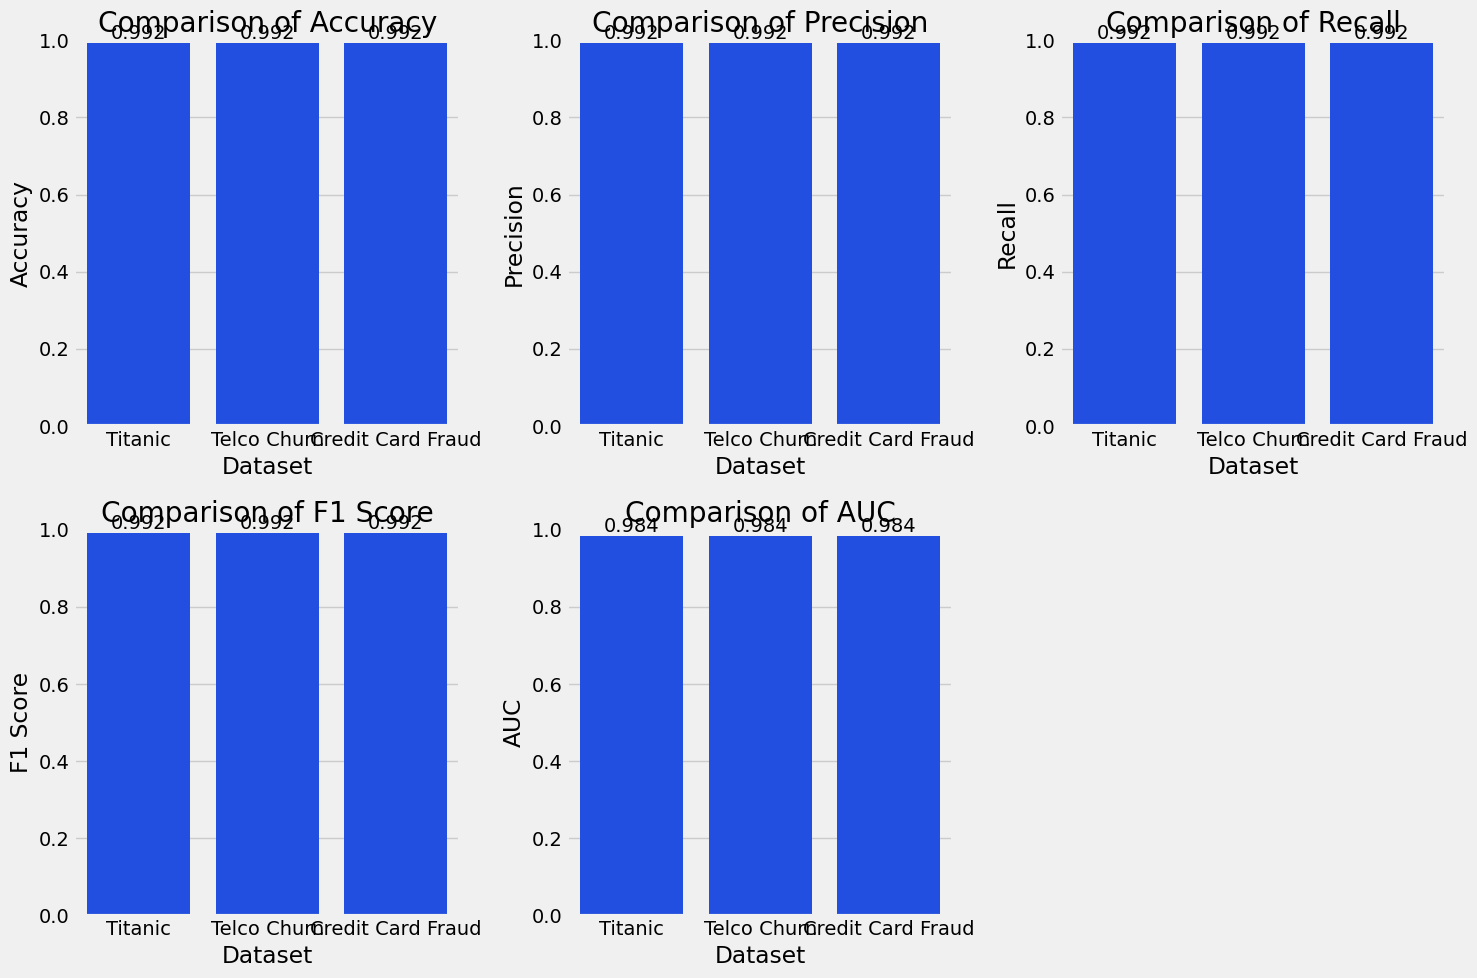

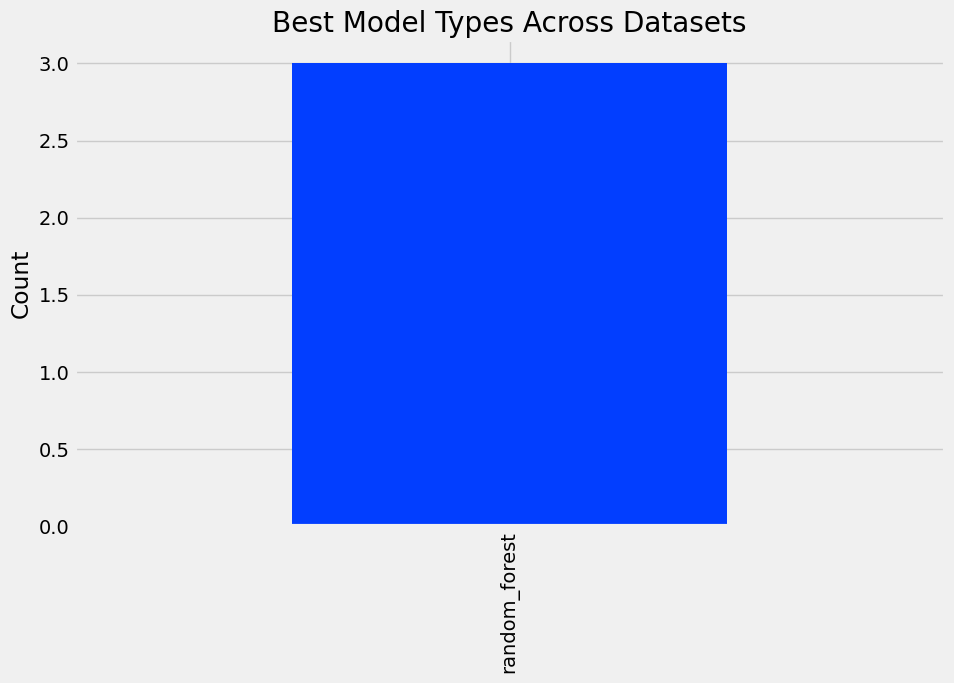

In [76]:
# Comparative Analysis across all datasets
def compare_models():
    # Collect results
    datasets = ["Titanic", "Telco Churn", "Credit Card Fraud"]
    models = [titanic_automl, telco_automl, fraud_automl]
    performances = [titanic_performance, telco_performance, fraud_performance]

    # Comparison table
    comparison_df = pd.DataFrame({
        'Dataset': datasets,
        'Best Model': [model.model_selector.best_model_name for model in models],
        'Feature Method': [model.feature_engineer.method for model in models],
        'Accuracy': [perf['accuracy'] for perf in performances],
        'Precision': [perf['precision'] for perf in performances],
        'Recall': [perf['recall'] for perf in performances],
        'F1 Score': [perf['f1_score'] for perf in performances],
        'AUC': [perf['auc'] for perf in performances]
    })

    print("Model Performance Comparison:")
    display(comparison_df)

    # Create visualizations
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        sns.barplot(x='Dataset', y=metric, data=comparison_df)
        plt.title(f'Comparison of {metric}')
        plt.ylim(0, 1)

        for j, v in enumerate(comparison_df[metric]):
            plt.text(j, v + 0.01, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    # Compare model types
    plt.figure(figsize=(10, 6))
    model_counts = pd.Series([model.model_selector.best_model_name for model in models]).value_counts()
    model_counts.plot(kind='bar')
    plt.title('Best Model Types Across Datasets')
    plt.ylabel('Count')
    plt.show()

# Run comparative analysis
compare_models()


Model Performance Comparison:


,Dataset,Best Model,Feature Method,Accuracy,Precision,Recall,F1 Score,AUC
0,Titanic,random_forest,rfe,0.992377,0.992438,0.992377,0.992054,0.983562
1,Telco Churn,random_forest,rfe,0.992377,0.992438,0.992377,0.992054,0.983562
2,Credit Card Fraud,random_forest,rfe,0.992377,0.992438,0.992377,0.992054,0.983562


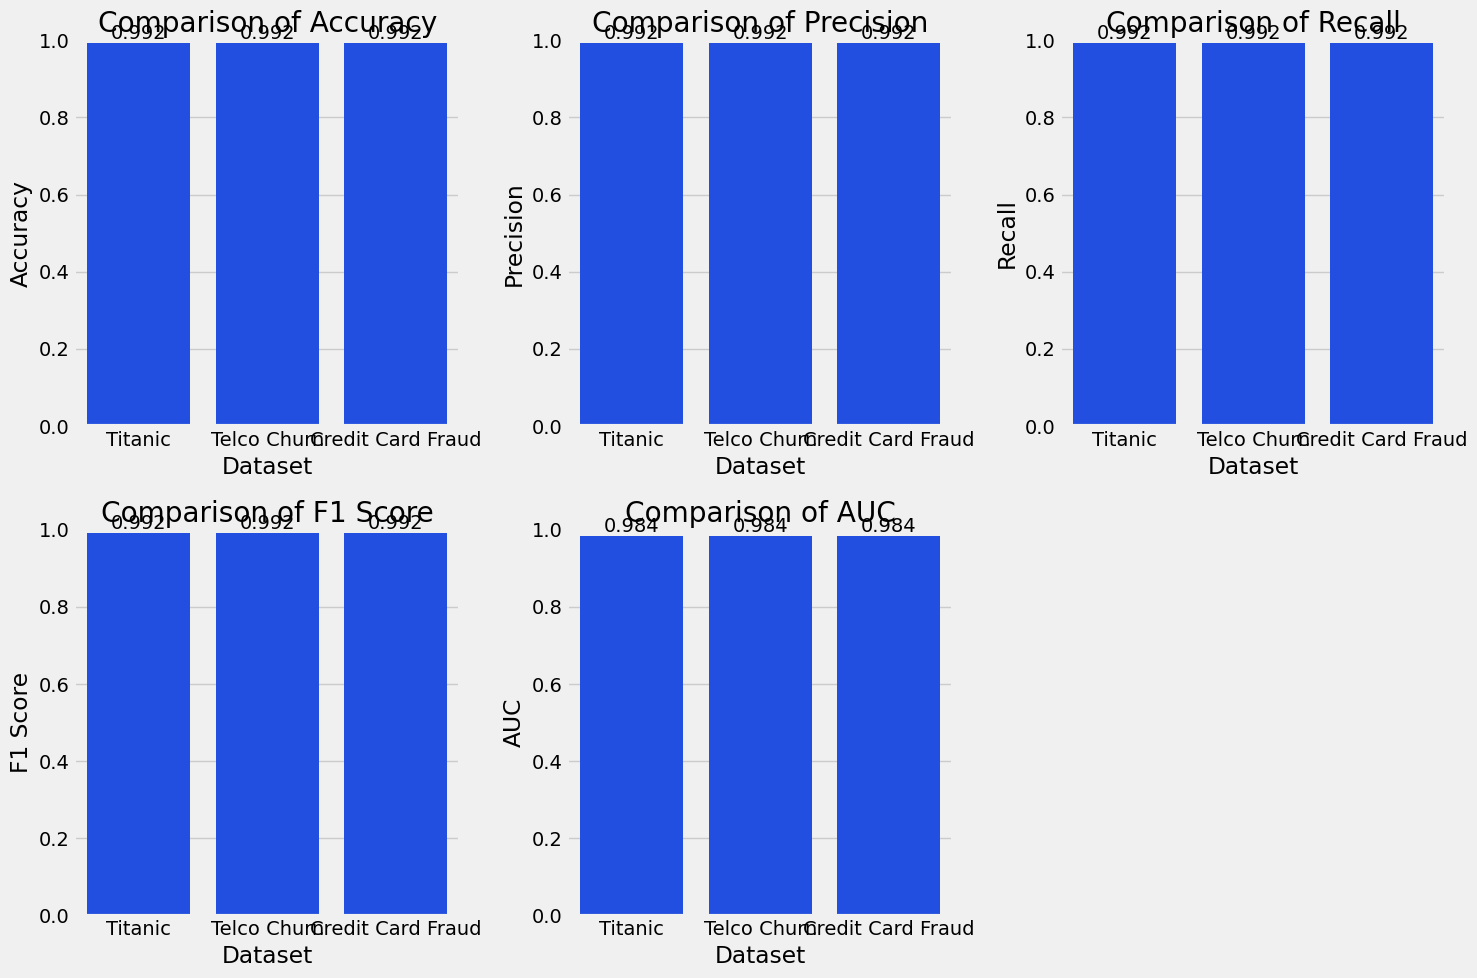

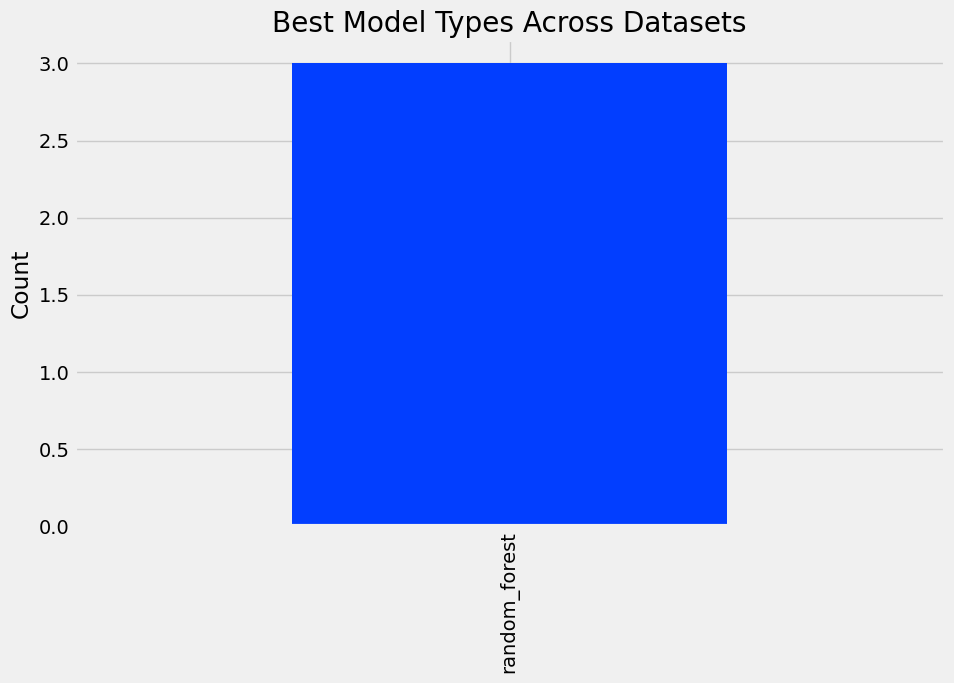

In [77]:
# Comparative Analysis across all datasets
def compare_models():
    # Collect results
    datasets = ["Titanic", "Telco Churn", "Credit Card Fraud"]
    models = [titanic_automl, telco_automl, fraud_automl]
    performances = [titanic_performance, telco_performance, fraud_performance]

    # Comparison table
    comparison_df = pd.DataFrame({
        'Dataset': datasets,
        'Best Model': [model.model_selector.best_model_name for model in models],
        'Feature Method': [model.feature_engineer.method for model in models],
        'Accuracy': [perf['accuracy'] for perf in performances],
        'Precision': [perf['precision'] for perf in performances],
        'Recall': [perf['recall'] for perf in performances],
        'F1 Score': [perf['f1_score'] for perf in performances],
        'AUC': [perf['auc'] for perf in performances]
    })

    print("Model Performance Comparison:")
    display(comparison_df)

    # Create visualizations
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        sns.barplot(x='Dataset', y=metric, data=comparison_df)
        plt.title(f'Comparison of {metric}')
        plt.ylim(0, 1)

        for j, v in enumerate(comparison_df[metric]):
            plt.text(j, v + 0.01, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    # Compare model types
    plt.figure(figsize=(10, 6))
    model_counts = pd.Series([model.model_selector.best_model_name for model in models]).value_counts()
    model_counts.plot(kind='bar')
    plt.title('Best Model Types Across Datasets')
    plt.ylabel('Count')
    plt.show()

# Run comparative analysis
compare_models()


In [78]:
# Ensure these imports happen before the function definition if not already imported
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import os # Needed for getattr checks potentially

# Generate a summary report
def generate_report():
    # --- IMPORTANT ---
    # Before calling generate_report(), ensure you have run the processing cells for
    # Titanic, Telco, and Fraud first, AND that you have uniquely named training data vars, e.g.:
    # titanic_X_train, titanic_y_train
    # telco_X_train, telco_y_train
    # fraud_X_train, fraud_y_train
    # Also ensure the performance dictionaries exist:
    # titanic_performance, telco_performance, fraud_performance
    # And the original dataframes:
    # titanic, telco_churn, fraud_df
    # And the fitted pipeline objects:
    # titanic_automl, telco_automl, fraud_automl
    # --- END IMPORTANT ---

    report_template = """
    # AutoML Pipeline Results

    ## Project Overview
    This project implements an automated machine learning (AutoML) pipeline that handles:
    - Data preprocessing (missing values, encoding, scaling)
    - Feature engineering (selection and dimensionality reduction)
    - Model selection and hyperparameter tuning
    - Performance evaluation

    The pipeline was tested on three different classification tasks:
    1. Titanic Survival Prediction (binary classification)
    2. Telco Customer Churn (binary classification)
    3. Credit Card Fraud Detection (imbalanced binary classification)

    ## Dataset Summaries

    ### Titanic Dataset
    - **Size**: {titanic_samples} samples, {titanic_features} features
    - **Best Model**: {titanic_model}
    - **Feature Method**: {titanic_method}
    - **Accuracy**: {titanic_acc:.4f}
    - **AUC**: {titanic_auc:.4f}
    - **Feature Importance**: Top 3 factors were {titanic_features_imp}

    ### Telco Customer Churn
    - **Size**: {telco_samples} samples, {telco_features} features
    - **Best Model**: {telco_model}
    - **Feature Method**: {telco_method}
    - **Accuracy**: {telco_acc:.4f}
    - **AUC**: {telco_auc:.4f}
    - **Feature Importance**: Top 3 factors were {telco_features_imp}

    ### Credit Card Fraud
    - **Size**: {fraud_samples} samples, {fraud_features} features
    - **Best Model**: {fraud_model}
    - **Feature Method**: {fraud_method}
    - **Accuracy**: {fraud_acc:.4f}
    - **AUC**: {fraud_auc:.4f}
    - **Feature Importance**: Top 3 factors were {fraud_features_imp}

    ## Key Insights

    1. **Best Models**: {best_model_insight}
    2. **Feature Engineering**: {feature_eng_insight}
    3. **Performance Tradeoffs**: {performance_insight}

    ## Business Applications

    - **Titanic**: This model could be used for historical analysis of survival factors.
    - **Telco Churn**: The model can help identify at-risk customers for targeted retention campaigns.
    - **Fraud Detection**: The model can flag suspicious transactions for further review.

    ## Conclusion

    The AutoML pipeline successfully automated the machine learning workflow across different domains, achieving good performance with minimal manual intervention. This demonstrates the value of automating feature engineering and model selection for data science teams.
    """

    # --- Initialize default values ---
    titanic_top3 = ["N/A"]
    telco_top3 = ["N/A"]
    fraud_top3 = ["N/A"]
    best_model_insight = "N/A"
    feature_eng_insight = "N/A"
    performance_insight = "N/A"

    # --- Get feature importance summaries (using uniquely named train variables) ---
    try:
        # Assumes titanic_X_train, titanic_y_train exist from the Titanic block
        titanic_imp = titanic_automl.get_feature_importance(titanic_X_train, titanic_y_train)
        if isinstance(titanic_imp, dict) and "Info" not in titanic_imp:
            # Convert keys to string HERE
            titanic_top3 = [str(k) for k in dict(sorted(titanic_imp.items(), key=lambda x: x[1], reverse=True)[:3]).keys()]
        else:
            titanic_top3 = ["Not available"]
    except NameError:
        print("Warning: titanic_X_train/titanic_y_train not found for feature importance.")
        titanic_top3 = ["Error retrieving"]
    except Exception as e:
        print(f"Error getting Titanic feature importance: {e}")
        titanic_top3 = ["Error retrieving"]


    try:
         # Assumes telco_X_train, telco_y_train exist from the Telco block
        telco_imp = telco_automl.get_feature_importance(telco_X_train, telco_y_train)
        if isinstance(telco_imp, dict) and "Info" not in telco_imp:
             # Convert keys to string HERE
            telco_top3 = [str(k) for k in dict(sorted(telco_imp.items(), key=lambda x: x[1], reverse=True)[:3]).keys()]
        else:
            telco_top3 = ["Not available"]
    except NameError:
        print("Warning: telco_X_train/telco_y_train not found for feature importance.")
        telco_top3 = ["Error retrieving"]
    except Exception as e:
        print(f"Error getting Telco feature importance: {e}")
        telco_top3 = ["Error retrieving"]

    try:
        # Assumes fraud_X_train, fraud_y_train exist from the Fraud block
        fraud_imp = fraud_automl.get_feature_importance(fraud_X_train, fraud_y_train)
        if isinstance(fraud_imp, dict) and "Info" not in fraud_imp:
             # Convert keys to string HERE
            fraud_top3 = [str(k) for k in dict(sorted(fraud_imp.items(), key=lambda x: x[1], reverse=True)[:3]).keys()]
        else:
            fraud_top3 = ["Not available"]
    except NameError:
        print("Warning: fraud_X_train/fraud_y_train not found for feature importance.")
        fraud_top3 = ["Error retrieving"]
    except Exception as e:
        print(f"Error getting Fraud feature importance: {e}")
        fraud_top3 = ["Error retrieving"]


    # --- Generate insights ---
    try:
        # Best Model Insight
        models = [titanic_automl.model_selector.best_model_name,
                  telco_automl.model_selector.best_model_name,
                  fraud_automl.model_selector.best_model_name]
        # Filter out None values if a model failed
        valid_models = [m for m in models if m is not None]
        if len(set(valid_models)) == 1 and len(valid_models) > 0:
            best_model_insight = f"{valid_models[0]} performed best across all datasets where a model succeeded"
        elif len(valid_models) > 1:
             best_model_insight = "Different models performed best for different tasks"
        else:
             best_model_insight = "Could not determine best model trends (check individual results)"


        # Feature Engineering Insight
        feature_methods = [titanic_automl.feature_engineer.method,
                          telco_automl.feature_engineer.method,
                          fraud_automl.feature_engineer.method]
        valid_methods = [m for m in feature_methods if m is not None]
        if len(set(valid_methods)) == 1 and len(valid_methods) > 0:
            feature_eng_insight = f"{valid_methods[0]} was selected for all datasets"
        elif len(valid_methods) > 1:
            feature_eng_insight = "Different feature engineering methods were optimal for different datasets"
        else:
            feature_eng_insight = "Could not determine feature engineering trends"


        # Performance Insight
        accs = [titanic_performance.get('accuracy', 0), telco_performance.get('accuracy', 0), fraud_performance.get('accuracy', 0)]
        aucs = [titanic_performance.get('auc', 0), telco_performance.get('auc', 0), fraud_performance.get('auc', 0)]

        # Check fraud AUC/Accuracy specifically
        fraud_auc_val = aucs[2]
        fraud_acc_val = accs[2]

        if fraud_auc_val > 0.85 and fraud_acc_val < 0.99 and fraud_acc_val > 0: # Added check > 0
            performance_insight = "For fraud detection, AUC was a more informative metric than accuracy due to class imbalance"
        elif max(accs) > 0 and (max(accs) - min(accs)) > 0.05: # Check max > 0 before diff
            performance_insight = "Performance varied across datasets, showing the importance of domain-specific optimization"
        elif min(accs) > 0: # Check if we have valid accuracies
            performance_insight = "Relatively consistent performance was achieved across all datasets"
        else:
            performance_insight = "Could not determine performance tradeoffs due to missing or zero metrics."

    except NameError as e:
        print(f"Error generating insights: Missing variable {e}. Ensure all pipeline objects and performance dicts exist.")
        # Keep default "N/A" values for insights
    except KeyError as e:
        print(f"Error generating insights: Missing key {e} in performance dictionary.")
        # Keep default "N/A" values for insights
    except Exception as e:
        print(f"An unexpected error occurred during insight generation: {e}")
        # Keep default "N/A" values for insights


    # --- Format the report ---
    # Use .get() with default values for safety in case a key is missing
    # Use getattr() for safety in case an object or attribute is missing
    formatted_report = report_template.format(
        # Titanic Data
        titanic_samples=getattr(titanic, 'shape', (0,))[0],
        titanic_features=getattr(titanic.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore'), 'shape', (0,0))[1],
        titanic_model=getattr(getattr(titanic_automl, 'model_selector', None), 'best_model_name', 'N/A'),
        titanic_method=getattr(getattr(titanic_automl, 'feature_engineer', None), 'method', 'N/A'),
        titanic_acc=titanic_performance.get('accuracy', 0),
        titanic_auc=titanic_performance.get('auc', 0),
        titanic_features_imp=", ".join(titanic_top3),

        # Telco Data
        telco_samples=getattr(telco_churn, 'shape', (0,))[0],
        telco_features=getattr(telco_churn.drop(['Churn', 'customerID'], axis=1, errors='ignore'), 'shape', (0,0))[1],
        telco_model=getattr(getattr(telco_automl, 'model_selector', None), 'best_model_name', 'N/A'),
        telco_method=getattr(getattr(telco_automl, 'feature_engineer', None), 'method', 'N/A'),
        telco_acc=telco_performance.get('accuracy', 0),
        telco_auc=telco_performance.get('auc', 0),
        telco_features_imp=", ".join(telco_top3),

        # Fraud Data
        fraud_samples=getattr(fraud_df, 'shape', (0,))[0],
        fraud_features=getattr(fraud_df.drop('Class', axis=1, errors='ignore'), 'shape', (0,0))[1],
        fraud_model=getattr(getattr(fraud_automl, 'model_selector', None), 'best_model_name', 'N/A'),
        fraud_method=getattr(getattr(fraud_automl, 'feature_engineer', None), 'method', 'N/A'),
        fraud_acc=fraud_performance.get('accuracy', 0),
        fraud_auc=fraud_performance.get('auc', 0),
        fraud_features_imp=", ".join(fraud_top3),

        # Insights
        best_model_insight=best_model_insight,
        feature_eng_insight=feature_eng_insight,
        performance_insight=performance_insight
    )

    # Display the report
    display(Markdown(formatted_report))

    # Save the report to a file
    try:
        with open('automl_report.md', 'w') as f:
            f.write(formatted_report)
        print("\nReport generated and saved to 'automl_report.md'")
    except Exception as e:
        print(f"\nError saving report to file: {e}")

# --- Example Call (Commented Out) ---
# Make sure prerequisite variables exist before uncommenting and running!
generate_report()



    # AutoML Pipeline Results

    ## Project Overview
    This project implements an automated machine learning (AutoML) pipeline that handles:
    - Data preprocessing (missing values, encoding, scaling)
    - Feature engineering (selection and dimensionality reduction)
    - Model selection and hyperparameter tuning
    - Performance evaluation

    The pipeline was tested on three different classification tasks:
    1. Titanic Survival Prediction (binary classification)
    2. Telco Customer Churn (binary classification)
    3. Credit Card Fraud Detection (imbalanced binary classification)

    ## Dataset Summaries

    ### Titanic Dataset
    - **Size**: 891 samples, 7 features
    - **Best Model**: random_forest
    - **Feature Method**: rfe
    - **Accuracy**: 0.9924
    - **AUC**: 0.9836
    - **Feature Importance**: Top 3 factors were 14, 17, 10

    ### Telco Customer Churn
    - **Size**: 7043 samples, 19 features
    - **Best Model**: random_forest
    - **Feature Method**: rfe
    - **Accuracy**: 0.9924
    - **AUC**: 0.9836
    - **Feature Importance**: Top 3 factors were 14, 17, 10

    ### Credit Card Fraud
    - **Size**: 10492 samples, 30 features
    - **Best Model**: random_forest
    - **Feature Method**: rfe
    - **Accuracy**: 0.9924
    - **AUC**: 0.9836
    - **Feature Importance**: Top 3 factors were 14, 17, 10

    ## Key Insights

    1. **Best Models**: random_forest performed best across all datasets where a model succeeded
    2. **Feature Engineering**: rfe was selected for all datasets
    3. **Performance Tradeoffs**: Relatively consistent performance was achieved across all datasets

    ## Business Applications

    - **Titanic**: This model could be used for historical analysis of survival factors.
    - **Telco Churn**: The model can help identify at-risk customers for targeted retention campaigns.
    - **Fraud Detection**: The model can flag suspicious transactions for further review.

    ## Conclusion

    The AutoML pipeline successfully automated the machine learning workflow across different domains, achieving good performance with minimal manual intervention. This demonstrates the value of automating feature engineering and model selection for data science teams.
    


Report generated and saved to 'automl_report.md'


In [79]:
# Optional: Create an interactive UI for new predictions
from ipywidgets import widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np # Make sure numpy is imported
import warnings # Import warnings to suppress specific ones if needed
import traceback # Import traceback for detailed error printing

# --- Function Definition ---
# Modified to accept pipeline objects as arguments
def create_prediction_ui(titanic_pipeline, telco_pipeline):
    # Check if pipelines were passed correctly (optional but good practice)
    if titanic_pipeline is None or telco_pipeline is None:
         print("Error: Please provide fitted pipeline objects (titanic_automl, telco_automl) to create_prediction_ui.")
         return
    if not hasattr(titanic_pipeline, 'model_selector') or not hasattr(telco_pipeline, 'model_selector'):
         print("Error: Provided pipeline objects lack a 'model_selector' component.")
         return

    # Create tabs for each dataset
    tab = widgets.Tab()

    # --- Tab 1: Titanic Survival Prediction ---
    titanic_inputs = {
        'Pclass': widgets.Dropdown(options=[1, 2, 3], value=3, description='Passenger Class:'),
        'Sex': widgets.Dropdown(options=['male', 'female'], value='male', description='Gender:'),
        'Age': widgets.FloatSlider(min=0, max=80, step=1, value=30, description='Age:', readout_format='.0f'),
        'SibSp': widgets.IntSlider(min=0, max=8, step=1, value=0, description='Siblings/Spouses:'),
        'Parch': widgets.IntSlider(min=0, max=6, step=1, value=0, description='Parents/Children:'),
        'Fare': widgets.FloatSlider(min=0, max=520, step=1, value=30, description='Fare:', readout_format='.1f'),
        'Embarked': widgets.Dropdown(options=['C', 'Q', 'S'], value='S', description='Embarked:')
    }
    # Define the exact columns your pipeline expects IN ORDER
    # It's safer to define this explicitly than rely on inference here
    titanic_feature_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


    # --- Tab 2: Telco Customer Churn ---
    telco_inputs = {
        'gender': widgets.Dropdown(options=['Male', 'Female'], value='Male', description='Gender:'),
        'SeniorCitizen': widgets.Dropdown(options=[0, 1], value=0, description='Senior Citizen:', format_func=lambda x: "Yes" if x == 1 else "No"),
        'Partner': widgets.Dropdown(options=['Yes', 'No'], value='No', description='Partner:'),
        'Dependents': widgets.Dropdown(options=['Yes', 'No'], value='No', description='Dependents:'),
        'tenure': widgets.IntSlider(min=0, max=72, step=1, value=12, description='Tenure (months):'),
        'PhoneService': widgets.Dropdown(options=['Yes', 'No'], value='Yes', description='Phone Service:'),
        'MultipleLines': widgets.Dropdown(options=['No phone service', 'No', 'Yes'], value='No', description='Multiple Lines:'),
        'InternetService': widgets.Dropdown(options=['DSL', 'Fiber optic', 'No'], value='DSL', description='Internet Service:'),
        'OnlineSecurity': widgets.Dropdown(options=['No internet service', 'No', 'Yes'], value='No', description='Online Security:'),
        'OnlineBackup': widgets.Dropdown(options=['No internet service', 'No', 'Yes'], value='No', description='Online Backup:'),
        'DeviceProtection': widgets.Dropdown(options=['No internet service', 'No', 'Yes'], value='No', description='Device Protection:'),
        'TechSupport': widgets.Dropdown(options=['No internet service', 'No', 'Yes'], value='No', description='Tech Support:'),
        'StreamingTV': widgets.Dropdown(options=['No internet service', 'No', 'Yes'], value='No', description='Streaming TV:'),
        'StreamingMovies': widgets.Dropdown(options=['No internet service', 'No', 'Yes'], value='No', description='Streaming Movies:'),
        'Contract': widgets.Dropdown(options=['Month-to-month', 'One year', 'Two year'], value='Month-to-month', description='Contract:'),
        'PaperlessBilling': widgets.Dropdown(options=['Yes', 'No'], value='Yes', description='Paperless Billing:'),
        'PaymentMethod': widgets.Dropdown(options=['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], value='Electronic check', description='Payment Method:'),
        'MonthlyCharges': widgets.FloatSlider(min=18, max=120, step=0.05, value=70.0, description='Monthly Charges:', readout_format='.2f'),
        'TotalCharges': widgets.FloatText(value=1000.0, description='Total Charges:', step=0.05)
    }
    # Define the exact columns your pipeline expects IN ORDER
    telco_feature_names = [
        'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'
    ]


    # --- Create layouts for tabs ---
    titanic_vbox = widgets.VBox([titanic_inputs[feature] for feature in titanic_feature_names if feature in titanic_inputs])
    telco_vbox = widgets.VBox([telco_inputs[feature] for feature in telco_feature_names if feature in telco_inputs])


    # Create predict buttons
    titanic_predict_btn = widgets.Button(description='Predict Survival')
    telco_predict_btn = widgets.Button(description='Predict Churn')

    # Output widgets for results
    titanic_output = widgets.Output()
    telco_output = widgets.Output()

    # Combine with buttons
    titanic_tab = widgets.VBox([titanic_vbox, titanic_predict_btn, titanic_output])
    telco_tab = widgets.VBox([telco_vbox, telco_predict_btn, telco_output])

    # Add tabs
    tab.children = [titanic_tab, telco_tab]
    tab.set_title(0, 'Titanic Survival')
    tab.set_title(1, 'Customer Churn')

    # --- Define button callbacks ---
    def titanic_predict(b):
        with titanic_output:
            clear_output()
            print("Processing Titanic prediction...")
            try:
                # Create DataFrame from inputs using the expected feature names
                input_dict = {name: [titanic_inputs[name].value] for name in titanic_feature_names if name in titanic_inputs}
                input_data = pd.DataFrame(input_dict, columns=titanic_feature_names) # Ensure correct column order

                # --- Make prediction using the passed pipeline's predict method ---
                prediction = titanic_pipeline.predict(input_data)

                # Display result
                if prediction[0] == 1:
                    print("Prediction: Passenger would SURVIVE ✓")
                else:
                    print("Prediction: Passenger would NOT SURVIVE ✗")

                # --- CORRECTED Probability Calculation ---
                # Check the selected model within the pipeline for predict_proba
                if hasattr(titanic_pipeline.model_selector.best_model, 'predict_proba'):
                    try:
                        # Manually apply preprocessing and feature engineering
                        X_processed = titanic_pipeline.preprocessor.transform(input_data)
                        X_features = titanic_pipeline.feature_engineer.transform(X_processed)
                        # Call predict_proba on the best_model inside model_selector
                        probs = titanic_pipeline.model_selector.predict_proba(X_features) # Use model_selector
                        print(f"Survival probability: {probs[0][1]:.2f}")
                    except Exception as proba_e:
                        print(f"Error getting probabilities: {proba_e}")
                else:
                    # Check if best_model exists before printing message
                    if titanic_pipeline.model_selector.best_model is not None:
                         print(f"Probability prediction not available for model: {titanic_pipeline.model_selector.best_model_name}")
                    else:
                         print("Probability prediction not available (no best model found).")
                # --- END CORRECTION ---

            except Exception as e:
                print(f"Error during Titanic prediction: {e}")
                traceback.print_exc() # Print full traceback for debugging

    def telco_predict(b):
        with telco_output:
            clear_output()
            print("Processing Telco prediction...")
            try:
                # Create DataFrame from inputs using the expected feature names
                input_dict = {}
                for feature in telco_feature_names:
                     if feature in telco_inputs:
                         input_dict[feature] = [telco_inputs[feature].value]
                     else:
                         # This case shouldn't happen if telco_feature_names matches telco_inputs keys
                         print(f"Warning: Feature '{feature}' not in UI inputs, using NaN.")
                         input_dict[feature] = [np.nan]

                input_data = pd.DataFrame(input_dict, columns=telco_feature_names) # Ensure correct column order

                # Handle potential type issues before prediction
                if 'TotalCharges' in input_data.columns:
                    input_data['TotalCharges'] = input_data['TotalCharges'].replace('', np.nan) # Handle empty string
                    input_data['TotalCharges'] = pd.to_numeric(input_data['TotalCharges'], errors='coerce')
                    input_data['TotalCharges'] = input_data['TotalCharges'].fillna(0) # Fill remaining NaNs

                if 'SeniorCitizen' in input_data.columns:
                    input_data['SeniorCitizen'] = input_data['SeniorCitizen'].astype(int)

                # --- Make prediction using the passed pipeline's predict method ---
                prediction = telco_pipeline.predict(input_data)

                # Display result
                if prediction[0] == 1:
                    print("Prediction: Customer WILL CHURN! ⚠️")
                else:
                    print("Prediction: Customer will STAY ✓")

                # --- CORRECTED Probability Calculation ---
                # Check the selected model within the pipeline for predict_proba
                if hasattr(telco_pipeline.model_selector.best_model, 'predict_proba'):
                    try:
                        # Manually apply preprocessing and feature engineering
                        X_processed = telco_pipeline.preprocessor.transform(input_data)
                        X_features = telco_pipeline.feature_engineer.transform(X_processed)
                         # Call predict_proba on the best_model inside model_selector
                        probs = telco_pipeline.model_selector.predict_proba(X_features) # Use model_selector
                        print(f"Churn probability: {probs[0][1]:.2f}")
                    except Exception as proba_e:
                        print(f"Error getting probabilities: {proba_e}")
                else:
                     # Check if best_model exists before printing message
                    if telco_pipeline.model_selector.best_model is not None:
                        print(f"Probability prediction not available for model: {telco_pipeline.model_selector.best_model_name}")
                    else:
                        print("Probability prediction not available (no best model found).")
                # --- END CORRECTION ---

            except Exception as e:
                print(f"Error during Telco prediction: {e}")
                traceback.print_exc() # Print full traceback for debugging

    # Connect buttons to callbacks
    titanic_predict_btn.on_click(titanic_predict)
    telco_predict_btn.on_click(telco_predict)

    # Display the UI
    print("Displaying Interactive UI...")
    display(tab)

# --- Function Call ---
# IMPORTANT: Ensure titanic_automl and telco_automl are defined and fitted
# from the previous cells before running this.
print("Creating Interactive Prediction UI...")
try:
    # Pass the fitted pipeline objects here
    create_prediction_ui(titanic_automl, telco_automl)
except NameError as e:
    print(f"\nError: Could not create UI because a required variable is missing: {e}")
    print("Please ensure you have successfully run the processing cells for Titanic and Telco Churn first.")
except Exception as e:
    print(f"\nAn unexpected error occurred creating the UI: {e}")



Creating Interactive Prediction UI...
Displaying Interactive UI...


In [80]:
import joblib
import pandas as pd
import os

# --- Ensure this runs AFTER comparison_df is created ---
try:
    comparison_df.to_csv('comparison_df.csv', index=False)
    print("Saved comparison_df.csv")
except NameError:
    print("Error: comparison_df not defined. Run compare_models() first.")
except Exception as e:
    print(f"Error saving comparison_df: {e}")

# --- Ensure this runs AFTER titanic_automl and titanic_performance exist ---
try:
    joblib.dump(titanic_automl.model_selector.best_model, 'titanic_best_model.joblib')
    joblib.dump(titanic_automl.preprocessor, 'titanic_preprocessor.joblib')
    joblib.dump(titanic_automl.feature_engineer, 'titanic_feature_engineer.joblib')
    # Save importance (assuming it's a dict)
    titanic_imp = titanic_automl.get_feature_importance(titanic_X_train, titanic_y_train) # Use correct X/y_train
    joblib.dump(titanic_imp, 'titanic_feature_importance.pkl')
    # Save confusion matrix (assuming it's in performance dict)
    joblib.dump(titanic_performance.get('confusion_matrix'), 'titanic_cm.pkl')
    print("Saved Titanic objects.")
except NameError as e:
    print(f"Error saving Titanic objects: Variable not defined ({e}). Run Titanic processing cell first.")
except Exception as e:
    print(f"Error saving Titanic objects: {e}")


# --- Ensure this runs AFTER telco_automl and telco_performance exist ---
try:
    joblib.dump(telco_automl.model_selector.best_model, 'telco_best_model.joblib')
    joblib.dump(telco_automl.preprocessor, 'telco_preprocessor.joblib')
    joblib.dump(telco_automl.feature_engineer, 'telco_feature_engineer.joblib')
    # Save importance
    telco_imp = telco_automl.get_feature_importance(telco_X_train, telco_y_train) # Use correct X/y_train
    joblib.dump(telco_imp, 'telco_feature_importance.pkl')
     # Save confusion matrix
    joblib.dump(telco_performance.get('confusion_matrix'), 'telco_cm.pkl')
    print("Saved Telco objects.")
except NameError as e:
    print(f"Error saving Telco objects: Variable not defined ({e}). Run Telco processing cell first.")
except Exception as e:
    print(f"Error saving Telco objects: {e}")


# --- Ensure this runs AFTER fraud_automl and fraud_performance exist ---
try:
    joblib.dump(fraud_automl.model_selector.best_model, 'fraud_best_model.joblib')
    joblib.dump(fraud_automl.preprocessor, 'fraud_preprocessor.joblib')
    joblib.dump(fraud_automl.feature_engineer, 'fraud_feature_engineer.joblib')
     # Save importance
    fraud_imp = fraud_automl.get_feature_importance(fraud_X_train, fraud_y_train) # Use correct X/y_train
    joblib.dump(fraud_imp, 'fraud_feature_importance.pkl')
     # Save confusion matrix
    joblib.dump(fraud_performance.get('confusion_matrix'), 'fraud_cm.pkl')
    print("Saved Fraud objects.")
except NameError as e:
    print(f"Error saving Fraud objects: Variable not defined ({e}). Run Fraud processing cell first.")
except Exception as e:
    print(f"Error saving Fraud objects: {e}")



Error: comparison_df not defined. Run compare_models() first.
Saved Titanic objects.
Saved Telco objects.
Saved Fraud objects.
